# 1. Цель лабораторной работы

Изучить сложные способы подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей

# 2. Задание

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.
5. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.
7. Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
8. Постройте кривые обучения и валидации.

# 3. Ход выполнения работы

In [0]:
from google.colab import files

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [0]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving covid19-russia-cases.csv to covid19-russia-cases (1).csv
User uploaded file "covid19-russia-cases.csv" with length 281785 bytes


## Предварительная подготовка данных

Датасет - COVID-19 Russia regions cases. COVID-19 virus (coronavirus) has been starting to spread inside of Russia. This is important to investigate and understand the spreading from a very low level. The world-level data is representing Russia virus cases as a single point. But Russia is a very huge and heterogeneous country. For better analyze we have to consider Russia infection cases distributed by region. So this is a dataset of regions distributed COVID-19 virus inside of Russia.

In [0]:
data = pd.read_csv("covid19-russia-cases.csv", delimiter=';')

Верхушка данных и типы

In [0]:
data.head(5)

,Date,Region/City-Eng,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
0,26.01.2020,Diamond Princess,NaN,3.0,0.0,0.0,3.0,0.0,0.0
1,31.01.2020,Tyumen region,72.0,1.0,0.0,0.0,1.0,0.0,0.0
2,31.01.2020,Zabaykalsky Krai,75.0,1.0,0.0,0.0,1.0,0.0,0.0
3,12.02.2020,Tyumen region,72.0,0.0,0.0,1.0,1.0,0.0,1.0
4,12.02.2020,Zabaykalsky Krai,75.0,0.0,0.0,1.0,1.0,0.0,1.0


In [0]:
data.dtypes

Date                object
Region/City-Eng     object
Region_ID          float64
Day-Confirmed      float64
Day-Deaths         float64
Day-Recovered      float64
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

In [0]:
data.isnull().sum()

Date               0
Region/City-Eng    0
Region_ID          2
Day-Confirmed      0
Day-Deaths         0
Day-Recovered      0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

Уберем столбец с названиями и реобразуем дату в соответствующий временной формат:

In [0]:
df = data.copy()

df["Date"] = pd.to_datetime(df["Date"]).astype(np.int64)/1000000

df = df.drop(["Region/City-Eng"], axis=1)

df["Region_ID"] =df["Region_ID"].fillna(method='ffill')

df=df.dropna()

In [0]:
df.head(5)

,Date,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
1,1.580429e+12,72.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.580429e+12,75.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.606867e+12,72.0,0.0,0.0,1.0,1.0,0.0,1.0
4,1.606867e+12,75.0,0.0,0.0,1.0,1.0,0.0,1.0
5,1.583107e+12,50.0,1.0,0.0,0.0,1.0,0.0,0.0


In [0]:
df.dtypes

Date             float64
Region_ID        float64
Day-Confirmed    float64
Day-Deaths       float64
Day-Recovered    float64
Confirmed        float64
Deaths           float64
Recovered        float64
dtype: object

In [0]:
df.isnull().sum()

Date             0
Region_ID        0
Day-Confirmed    0
Day-Deaths       0
Day-Recovered    0
Confirmed        0
Deaths           0
Recovered        0
dtype: int64

Проверим размер набора данных:

In [0]:
df.shape

(4498, 8)

Проверим основные статистические характеристики набора данных:

In [0]:
df.describe()

,Date,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
count,4.498000e+03,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000
mean,1.590025e+12,44.236105,80.616052,0.848155,29.179191,1654.563139,15.745220,352.179858
std,6.111935e+09,25.034676,393.074041,5.128834,214.880010,9997.870475,108.936064,2274.627093
min,1.578096e+12,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.587082e+12,23.000000,5.000000,0.000000,0.000000,57.000000,0.000000,7.000000
50%,1.588637e+12,44.000000,23.000000,0.000000,3.000000,309.500000,3.000000,46.000000
75%,1.590365e+12,65.000000,54.000000,0.000000,18.000000,966.000000,8.000000,243.000000
max,1.607126e+12,95.000000,6703.000000,77.000000,8033.000000,169303.000000,2110.000000,61619.000000


## Разделение данных

Разделим данные на целевой столбец и признаки:

In [0]:
X = df.drop("Deaths", axis=1)
y = df["Deaths"]

In [0]:
print(X.head(), "\n")
print(y.unique()[1:20])

           Date  Region_ID  Day-Confirmed  ...  Day-Recovered  Confirmed  Recovered
1  1.580429e+12       72.0            1.0  ...            0.0        1.0        0.0
2  1.580429e+12       75.0            1.0  ...            0.0        1.0        0.0
3  1.606867e+12       72.0            0.0  ...            1.0        1.0        1.0
4  1.606867e+12       75.0            0.0  ...            1.0        1.0        1.0
5  1.583107e+12       50.0            1.0  ...            0.0        1.0        0.0

[5 rows x 7 columns] 

[ 2.  3.  8.  1. 11. 16. 19. 20. 27. 29. 31. 10. 38. 13.  4. 50. 58. 14.
 72.]


In [0]:
print(X.shape)
print(y.shape)

(4498, 7)
(4498,)


Предобработка

In [0]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Date,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Recovered
count,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03
mean,-1.691459e-14,-1.419743e-16,1.330022e-16,3.543828e-15,-4.230350e-16,5.504218e-17,-2.970365e-16
std,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00
min,-1.951890e+00,-1.727241e+00,-2.051141e-01,-1.653883e-01,-1.358080e-01,-1.654099e-01,-1.548469e-01
25%,-4.815543e-01,-8.483619e-01,-1.923924e-01,-1.653883e-01,-1.358080e-01,-1.598081e-01,-1.517692e-01
50%,-2.270731e-01,-9.432165e-03,-1.465944e-01,-1.653883e-01,-1.218452e-01,-1.345499e-01,-1.346216e-01
75%,5.568388e-02,8.294976e-01,-6.772009e-02,-1.653883e-01,-5.203106e-02,-6.887864e-02,-4.800435e-02
max,2.798426e+00,2.027969e+00,1.684955e+01,1.484944e+01,3.725200e+01,1.677028e+01,2.693788e+01


Разделение на тренировочную/тестовую выборку

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3373, 7)
(1125, 7)
(3373,)
(1125,)


## Модель ближайших соседей для произвольно заданного гиперпараметра K

Функция, которая считает метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

Метод ближайших соседей с гиперпараметром K=8:

In [0]:
reg_8 = KNeighborsRegressor(n_neighbors=8)
reg_8.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                    weights='uniform')

Метрики построенной модели:

In [0]:
test_model(reg_8)

mean_absolute_error: 4.476222222222222
median_absolute_error: 1.375
r2_score: 0.9681805941812701


В данном случае модель более-менее состоятельна.

## Использование кросс-валидации

Классический K-fold:

In [0]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=8), X, y,
                         cv=KFold(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[-1.23346497 -1.16064018  0.39373978  0.89800484  0.89490998  0.93320972
  0.9833695   0.98393779  0.98549023  0.93877734]
0.4617334034900991 ± 0.8460127140273787


In [0]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=8), X, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=2),
                         scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.95831664 0.98896759 0.97655838 0.9791019  0.9956321  0.93504683
 0.98792121 0.98974114 0.98176949 0.96618188]
0.9759237157645103 ± 0.017360683340612883


In [0]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=8), X, y,
                         cv=ShuffleSplit(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.9906155  0.97566016 0.97643205 0.99456111 0.98004888 0.97669361
 0.96425757 0.98982402 0.9935453  0.99470175]
0.9836339948337299 ± 0.009894980917682168


## Подбор гиперпараметра K

Генерация массива разных значений K

In [0]:
n_range = np.array(range(1, 50, 2))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

Подбор параметра:

In [0]:
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'n_neighbors': 3}

Результаты при разных значения гиперпараметра на тренировочном наборе данных:

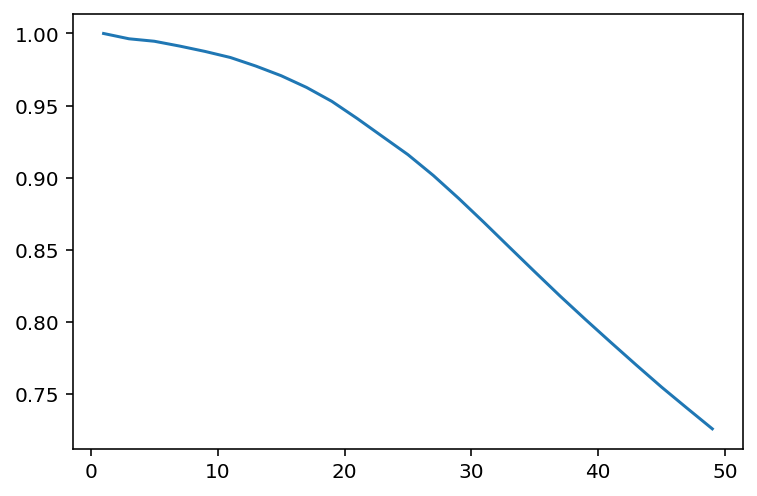

In [0]:
plt.plot(n_range, gs.cv_results_["mean_train_score"]);

Очевидно, что для K=1 на тренировочном наборе данных мы находим ровно ту же точку, что и нужно предсказать, и чем больше её соседей мы берём — тем меньше точность.

На тестовом наборе:

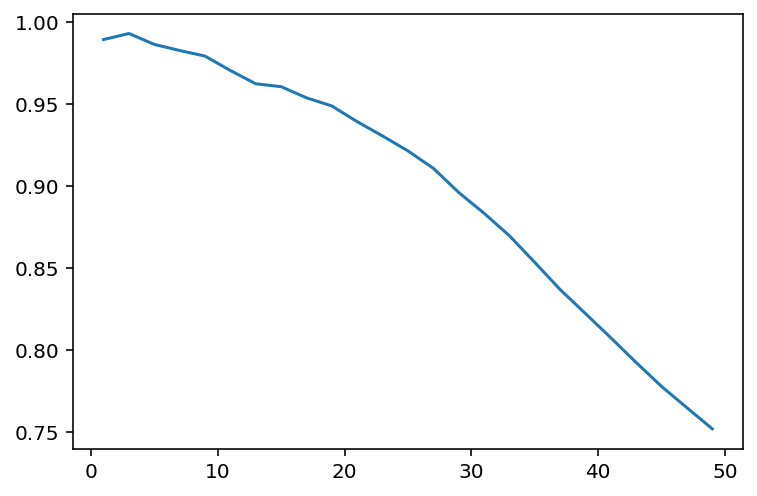

In [0]:
plt.plot(n_range, gs.cv_results_["mean_test_score"]);

Сначала увеличение количества соседей увеличивает точность, однако она довольно быстро достигает пика и начинает уменьшаться при дальнейщем увеличении числа соседей.

Проверим получившуюся модель:

In [0]:
reg = KNeighborsRegressor(**gs.best_params_)
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 3.2595555555555555
median_absolute_error: 1.0
r2_score: 0.9901989696273784


В целом получили примерно тот же результат. Очевидно, что проблема в том, что данный метод и так показал достаточно хороший результат для данной выборки.

Построим кривую обучения:

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    train_sizes=np.linspace(.1, 1.0, 5)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

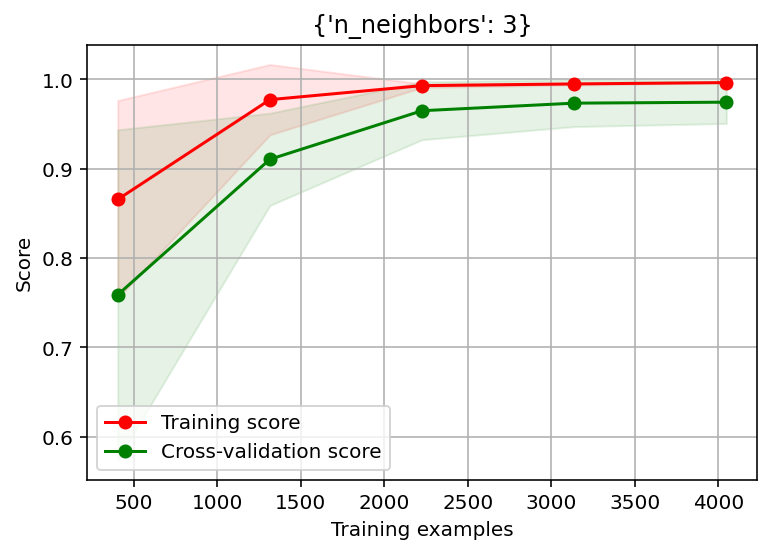

In [0]:
plot_learning_curve(reg, str(gs.best_params_), X, y,
                    cv=ShuffleSplit(n_splits=10));

Построим кривую валидации:

In [0]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name,
        param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean,
                 label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

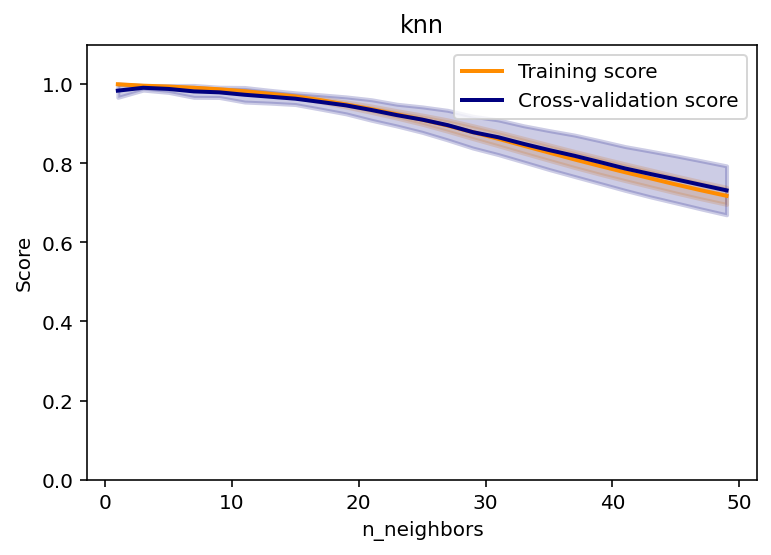

In [0]:
plot_validation_curve(KNeighborsRegressor(), "knn", X, y, 
                      param_name="n_neighbors", param_range=n_range, 
                      cv=ShuffleSplit(n_splits=10), scoring="r2");